### Experiments for Section III.A
- Here we compare batch number and size.
- We investigate how $k/n$ affects BD algorithm's performance.

In [ ]:
import numpy as np
from scipy.stats import wasserstein_distance_nd
from scipy.stats import ttest_rel
from kernel_2sample_test import *
from sklearn.metrics import pairwise_distances
from KL_div import *

def prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size):
    train_set = np.random.multivariate_normal(ref_mean, ref_cov, size)
    ref_set = np.random.multivariate_normal(ref_mean, ref_cov, size)
    det_set = np.random.multivariate_normal(det_mean, det_cov, size)
    return [train_set, ref_set, det_set]

def MMD_mul_D(set1, set2):
    len1 = len(set1)
    len2 = len(set2)
    combined_set = np.vstack([set1, set2])
    sigma2 = np.median(pairwise_distances(set1, set2, metric='euclidean'))**2
    K = pairwise_kernels(combined_set, metric="rbf", gamma=1.0/(2*sigma2))
    return MMD2u(K, len1, len2)

def energy_dist(set_1, set_2):
    '''
    set_1, set_2: multi-dimensional numpy arrays
    '''
    import torch
    import dcor
    set_1 = torch.from_numpy(set_1)
    set_2 = torch.from_numpy(set_2)
    return dcor.energy_distance(set_1, set_2)

def batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, dist):
    '''
    Returns whether there is a concept drift; True or False.
    '''
    train_batches = np.array_split(train_set, batch_num)
    ref_batches = np.array_split(ref_set, batch_num)
    det_batches = np.array_split(det_set, batch_num)
    train_ref_distances = np.zeros(batch_num)
    train_det_distances = np.zeros(batch_num)
    for i in range(batch_num):
        train_batch = train_batches[i]
        ref_batch = ref_batches[i]
        det_batch = det_batches[i]
        if dist == "EMD":
            train_ref_distances[i] = wasserstein_distance_nd(train_batch, ref_batch)
            train_det_distances[i] = wasserstein_distance_nd(train_batch, det_batch)
        elif dist == "MMD":
            train_ref_distances[i] = MMD_mul_D(train_batch, ref_batch)
            train_det_distances[i] = MMD_mul_D(train_batch, det_batch)
        elif dist == "KL":
            train_ref_distances[i] = KLdivergence(train_batch, ref_batch)
            train_det_distances[i] = KLdivergence(train_batch, det_batch)
        elif dist == "ED":
            train_ref_distances[i] = energy_dist(train_batch, ref_batch)
            train_det_distances[i] = energy_dist(train_batch, det_batch)
    _, p_val = ttest_rel(train_ref_distances, train_det_distances)
    print(dist + " BD p_val", p_val)
    if p_val < sig_lvl:
        print("BD Drift detected: True")
        return True
    elif p_val >= sig_lvl:
        print("BD Drift detected: False")
        return False

### The following code is for Figure 2(a) No drift.

In [ ]:
np.random.seed(0)
dim = 100
num_sim = 100
size = 5000
sig_lvl = 0.05
batch_size_lst = [5,25,50,100,200,250,500]
EMD_FPR_lst = np.zeros(len(batch_size_lst))
MMD_FPR_lst = np.zeros(len(batch_size_lst))
KL_FPR_lst = np.zeros(len(batch_size_lst))
for idx in range(len(batch_size_lst)):
    batch_size = batch_size_lst[idx]
    print("-> batch_size:", batch_size)
    FPR = 0
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(dim)
        ref_cov = np.eye(dim)
        det_mean = np.zeros(dim)
        det_cov = np.eye(dim)
        batch_num = int(size / batch_size)
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_EMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "EMD")
        BD_MMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "MMD")
        BD_KL_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "KL")
        if BD_EMD_algo_output == True:
            EMD_FPR_lst[idx] += 1
        if BD_MMD_algo_output == True:
            MMD_FPR_lst[idx] += 1
        if BD_KL_algo_output == True:
            KL_FPR_lst[idx] += 1
EMD_FPR_lst = EMD_FPR_lst / num_sim
MMD_FPR_lst = MMD_FPR_lst / num_sim
KL_FPR_lst = KL_FPR_lst / num_sim
print("EMD_FPR_lst", EMD_FPR_lst)
print("MMD_FPR_lst", MMD_FPR_lst)
print("KL_FPR_lst", KL_FPR_lst)
# batch size 500 took 332 min
# EMD_FPR_lst [0.05 0.04 0.04 0.05 0.06 0.06 0.04]
# MMD_FPR_lst [0.06 0.11 0.08 0.07 0.04 0.06 0.03]
# KL_FPR_lst [0.07 0.07 0.03 0.03 0.04 0.04 0.03]

### The following code is for Figure 2(b) Mean drift, all dimen.

In [ ]:
np.random.seed(0)
dim = 100
num_sim = 100
size = 5000
sig_lvl = 0.05
mean_drift = 0.03
batch_size_lst = [5,25,50,100,200,250,500]
EMD_FNR_lst = np.zeros(len(batch_size_lst))
MMD_FNR_lst = np.zeros(len(batch_size_lst))
KL_FNR_lst = np.zeros(len(batch_size_lst))
for idx in range(len(batch_size_lst)):
    batch_size = batch_size_lst[idx]
    print("-> batch_size:", batch_size)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.ones(100) * mean_drift
        det_cov = np.eye(100)
        batch_num = int(size / batch_size)
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_EMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "EMD")
        BD_MMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "MMD")
        BD_KL_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "KL")
        if BD_EMD_algo_output == False:
            EMD_FNR_lst[idx] += 1
        if BD_MMD_algo_output == False:
            MMD_FNR_lst[idx] += 1
        if BD_KL_algo_output == False:
            KL_FNR_lst[idx] += 1
EMD_FNR_lst = EMD_FNR_lst / num_sim
MMD_FNR_lst = MMD_FNR_lst / num_sim
KL_FNR_lst = KL_FNR_lst / num_sim
print("EMD_FNR_lst", EMD_FNR_lst)
print("MMD_FNR_lst", MMD_FNR_lst)
print("KL_FNR_lst", KL_FNR_lst)
# 332 min to run batch size = 500
# EMD_FNR_lst [0.93 0.93 0.95 0.93 0.95 0.94 0.96]
# MMD_FNR_lst [0.9 0.8  0.7  0.52 0.37 0.28 0.09]
# KL_FNR_lst [0.93 0.91 0.95 0.97 0.96 0.93 0.94]

### The following code is for Figure 2(c) Var drift, all dimen.

In [ ]:
np.random.seed(0)
dim = 100
num_sim = 100
size = 5000
sig_lvl = 0.05
var_drift = 1.01
batch_size_lst = [5,25,50,100,200,250,500]
EMD_FNR_lst = np.zeros(len(batch_size_lst))
MMD_FNR_lst = np.zeros(len(batch_size_lst))
KL_FNR_lst = np.zeros(len(batch_size_lst))
for idx in range(len(batch_size_lst)):
    batch_size = batch_size_lst[idx]
    print("-> batch_size:", batch_size)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        np.fill_diagonal(det_cov, var_drift)
        batch_num = int(size / batch_size)
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_EMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "EMD")
        BD_MMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "MMD")
        BD_KL_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "KL")
        if BD_EMD_algo_output == False:
            EMD_FNR_lst[idx] += 1
        if BD_MMD_algo_output == False:
            MMD_FNR_lst[idx] += 1
        if BD_KL_algo_output == False:
            KL_FNR_lst[idx] += 1
EMD_FNR_lst = EMD_FNR_lst / num_sim
MMD_FNR_lst = MMD_FNR_lst / num_sim
KL_FNR_lst = KL_FNR_lst / num_sim
print("EMD_FNR_lst", EMD_FNR_lst)
print("MMD_FNR_lst", MMD_FNR_lst)
print("KL_FNR_lst", KL_FNR_lst)
# batch size 500 took 329min
# EMD_FNR_lst [0.28 0.21 0.17 0.14 0.21 0.2 0.24]
# MMD_FNR_lst [0.94 0.89 0.92 0.93 0.96 0.94 0.97]
# KL_FNR_lst [0.41 0.37 0.45 0.53 0.61 0.6 0.64]

### The following code is for Figure 2(d) Cov drift, all off-diag.

In [ ]:
def get_cov(dim, off_diag):
    cov = np.ones((dim,dim)) * off_diag
    np.fill_diagonal(cov, 1)
    return cov

np.random.seed(0)
dim = 100
num_sim = 100
size = 5000
sig_lvl = 0.05
cov_drift = 0.07
batch_size_lst = [5,25,50,100,200,250,500]
EMD_FNR_lst = np.zeros(len(batch_size_lst))
MMD_FNR_lst = np.zeros(len(batch_size_lst))
KL_FNR_lst = np.zeros(len(batch_size_lst))
for idx in range(len(batch_size_lst)):
    batch_size = batch_size_lst[idx]
    print("-> batch_size:", batch_size)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        det_cov = get_cov(100, cov_drift)
        batch_num = int(size / batch_size)
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_EMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "EMD")
        BD_MMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "MMD")
        BD_KL_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "KL")
        if BD_EMD_algo_output == False:
            EMD_FNR_lst[idx] += 1
        if BD_MMD_algo_output == False:
            MMD_FNR_lst[idx] += 1
        if BD_KL_algo_output == False:
            KL_FNR_lst[idx] += 1
EMD_FNR_lst = EMD_FNR_lst / num_sim
MMD_FNR_lst = MMD_FNR_lst / num_sim
KL_FNR_lst = KL_FNR_lst / num_sim
print("EMD_FNR_lst", EMD_FNR_lst)
print("MMD_FNR_lst", MMD_FNR_lst)
print("KL_FNR_lst", KL_FNR_lst)
# batch size 500 took 333min
# EMD_FNR_lst [0.94 0.97 0.98 0.95 0.9 0.94 0.86]
# MMD_FNR_lst [0.92 0.75 0.68 0.37 0.13 0.05 0.]
# KL_FNR_lst [0.07 0. 0.01 0. 0. 0.01 0.02]

### The following code is to display all the plots in Fig. 2.

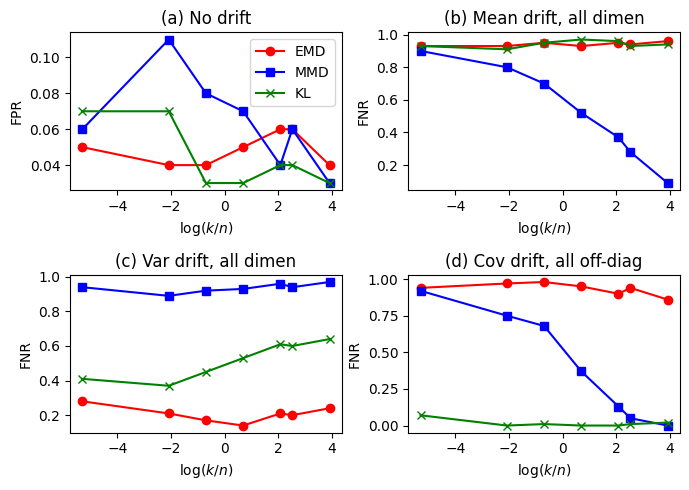

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# batch sizes k in [5,25,50,100,200,250,500]
ratio_lst = np.array([np.log(5/(5000/5)),np.log(25/(5000/25)),np.log(50/(5000/50)),np.log(100/(5000/100)),np.log(200/(5000/200)),np.log(250/(5000/250)),np.log(500/(5000/500))])
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(7, 5))

'''Fig. 2 (a): No drift'''
EMD_FPR_lst = np.array([0.05,0.04,0.04,0.05,0.06,0.06,0.04])
MMD_FPR_lst = np.array([0.06,0.11,0.08,0.07,0.04,0.06,0.03])
KL_FPR_lst = np.array([0.07,0.07,0.03,0.03,0.04,0.04,0.03])
axes[0,0].plot(ratio_lst, EMD_FPR_lst, marker='o', c='r', label='EMD')
axes[0,0].plot(ratio_lst, MMD_FPR_lst, marker='s', c='b', label='MMD')
axes[0,0].plot(ratio_lst, KL_FPR_lst, marker='x', c='g', label='KL')
axes[0,0].set_title("(a) No drift")
axes[0,0].legend(loc="upper right")
axes[0,0].set(xlabel=r'$\log(k/n)$', ylabel='FPR')

'''Fig. 2 (b): Mean drift in all dimensions'''
EMD_FPR_lst = np.array([0.93,0.93,0.95,0.93,0.95,0.94,0.96])
MMD_FPR_lst = np.array([0.9,0.8,0.7,0.52,0.37,0.28,0.09])
KL_FPR_lst = np.array([0.93,0.91,0.95,0.97,0.96,0.93,0.94])
axes[0,1].plot(ratio_lst, EMD_FPR_lst, marker='o', c='r')
axes[0,1].plot(ratio_lst, MMD_FPR_lst, marker='s', c='b')
axes[0,1].plot(ratio_lst, KL_FPR_lst, marker='x', c='g')
axes[0,1].set_title("(b) Mean drift, all dimen")
axes[0,1].set(xlabel=r'$\log(k/n)$', ylabel='FNR')

'''Fig. 2 (c): Variance drift in all dimensions'''
EMD_FPR_lst = np.array([0.28,0.21,0.17,0.14,0.21,0.2,0.24])
MMD_FPR_lst = np.array([0.94,0.89,0.92,0.93,0.96,0.94,0.97])
KL_FPR_lst = np.array([0.41,0.37,0.45,0.53,0.61,0.6,0.64])
axes[1,0].plot(ratio_lst, EMD_FPR_lst, marker='o', c='r')
axes[1,0].plot(ratio_lst, MMD_FPR_lst, marker='s', c='b')
axes[1,0].plot(ratio_lst, KL_FPR_lst, marker='x', c='g')
axes[1,0].set_title("(c) Var drift, all dimen")
axes[1,0].set(xlabel=r'$\log(k/n)$', ylabel='FNR')

'''Fig. 2 (d): Covariance drift in all off-diagonals'''
EMD_FPR_lst = np.array([0.94,0.97,0.98,0.95,0.9,0.94,0.86])
MMD_FPR_lst = np.array([0.92,0.75,0.68,0.37,0.13,0.05,0])
KL_FPR_lst = np.array([0.07,0,0.01,0,0,0.01,0.02])
axes[1,1].plot(ratio_lst, EMD_FPR_lst, marker='o', c='r')
axes[1,1].plot(ratio_lst, MMD_FPR_lst, marker='s', c='b')
axes[1,1].plot(ratio_lst, KL_FPR_lst, marker='x', c='g')
axes[1,1].set_title("(d) Cov drift, all off-diag")
axes[1,1].set(xlabel=r'$\log(k/n)$', ylabel='FNR')

fig.tight_layout() 

### Experiments for Section III.B
- Here we come the BD algorithm vs the other methods, we look at
    - BD with all 3 distances
    - KS with Bonferroni correction
    - MMD with permutation test
- We consider the "limited time, unlimited data" setting, where we control the number of iterations and then compare the power of different approaches
- Restrict total number of iterations to around $10^8$.
- Restrict $m=100$ and $B=100$.
- The chosen parameter sizes are displayed in the following table:

| Approach | Complexity | parameters |
| --- | --- | --- |
| EMD-BD | $O(n(k^3+mk^2))$ | $n=50,k=100$ |
| EMD-PT | $O(B(n^3k^3+mn^2k^2))$ | $nk=76$ |
| MMD-BD | $O(mnk^2)$ | $n=100,k=100$ |
| MMD-PT | $O(Bmn^2k^2)$ | $nk=100$ |
| KL-BD| $O(mnk^2)$ | $n=100,k=100$ |
| KL-PT| $O(Bmn^2k^2)$ | $nk=100$ |
| KS-BC| $O(mnk\log(nk))$ | $nk=87900$ |

In [ ]:
'''Code to do permutation testing for a given distance (e.g., EMD, KL)'''
'''MMD test code in kernel_2sample_test.py already contains permutation testing for MMD'''
from kernel_2sample_test import *

def run_perm_test(train_set, ref_set, det_set, sig_lvl, distance, iterations=100, marker_interval=10):
    non_det_set = np.concatenate((train_set, ref_set), axis=0)
    permuted_stats = np.zeros(iterations)
    non_det_len = len(non_det_set)
    det_len = len(det_set)
    stat = 0
    if distance == "EMD":
        stat = wasserstein_distance_nd(non_det_set, det_set)
    elif distance == "MMD":
        sigma2 = np.median(pairwise_distances(non_det_set, det_set, metric='euclidean'))**2
        matrix = np.vstack([non_det_set, det_set])
        K = pairwise_kernels(matrix, metric='rbf', gamma=1.0/(2*sigma2))
        stat = MMD2u(K, non_det_len, det_len)
    elif distance == "KL":
        stat = KLdivergence(non_det_set, det_set)
    rng = np.random.RandomState(None)
    for i in range(iterations):
        if (i % marker_interval) == 0:
            print("permutation testing index:", i)
        idx = rng.permutation(non_det_len+det_len)
        permuted_set = np.concatenate((non_det_set, det_set), axis=0)[idx]
        permuted_set1 = permuted_set[:non_det_len]
        permuted_set2 = permuted_set[non_det_len:]
        if distance == "EMD":
            permuted_stats[i] = wasserstein_distance_nd(permuted_set1, permuted_set2)
        elif distance == "MMD":
            K_i = K[idx, idx[:, None]]
            permuted_stats[i] = MMD2u(K_i, non_det_len, det_len)
        elif distance == "KL":
            permuted_stats[i] = KLdivergence(permuted_set1, permuted_set2)
    p_val = max(1.0/iterations, (permuted_stats > stat).sum() / float(iterations))
    print(distance + " p_value", p_val)
    if p_val < sig_lvl:
        return True
    elif p_val >= sig_lvl:
        return False

In [ ]:
from scipy.stats import ks_2samp
from kernel_2sample_test import *

def KS_algo(train_set, ref_set, det_set, sig_lvl, should_print):
    '''
    Works only for single dimension.
    Returns whether there is a concept drift in the specified dimension: True or False.
    '''
    non_det_set = np.concatenate((train_set, ref_set), axis=0)
    _, p_val = ks_2samp(non_det_set, det_set)
    if should_print:
        print("KS p_val", p_val)
    if p_val < sig_lvl:
        return True
    elif p_val >= sig_lvl:
        return False

def KS_BC_algo(train_set, ref_set, det_set, sig_lvl):
    '''
    Applies Bonferroni correction.
    '''
    dimen = len(ref_set[0])
    output = False
    for dim_i in range(dimen):
        train_set_i = train_set[:, dim_i]
        ref_set_i = ref_set[:, dim_i]
        det_set_i = det_set[:, dim_i]
        rej_hypo = KS_algo(train_set_i, ref_set_i, det_set_i, sig_lvl/dimen, dim_i==dimen-1)
        output = output or rej_hypo
    print("KS+BC drift detected:", output)
    return output

def MMD_algo(train_set, ref_set, det_set, sig_lvl):
    '''
    Returns whether there is a concept drift; True or False.
    '''
    non_det_set = np.concatenate((train_set, ref_set), axis=0)
    sigma2 = np.median(pairwise_distances(non_det_set, det_set, metric='euclidean'))**2
    _, _, p_val = kernel_two_sample_test(non_det_set, det_set, kernel_function='rbf', iterations=100, gamma=1.0/(2*sigma2), verbose=False)
    # Every 10 iteration (permutation) for nk=10000 takes 1 minute to run...
    print("MMD p_val", p_val)
    if p_val < sig_lvl:
        return True
    elif p_val >= sig_lvl:
        return False

### The following code is for the no drift experiment in Section III.B.

In [ ]:
np.random.seed(0)
num_sim = 100
sig_lvl = 0.05
FPR_BD_EMD = 0
FPR_BD_MMD = 0
FPR_BD_KL = 0
for sim_i in range(num_sim):
    print("...Simulation:", sim_i+1)
    ref_mean = np.zeros(100)
    ref_cov = np.eye(100)
    det_mean = np.zeros(100)
    det_cov = np.eye(100)
    batch_num = 50
    batch_size = 100
    size = batch_num * batch_size
    train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    BD_EMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "EMD")
    batch_num = 100
    batch_size = 100
    size = batch_num * batch_size
    train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    BD_MMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "MMD")
    BD_KL_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "KL")
    if BD_EMD_algo_output == True:
        FPR_BD_EMD += 1
    if BD_MMD_algo_output == True:
        FPR_BD_MMD += 1
    if BD_KL_algo_output == True:
        FPR_BD_KL += 1
FPR_BD_EMD = FPR_BD_EMD / num_sim
FPR_BD_MMD = FPR_BD_MMD / num_sim
FPR_BD_KL = FPR_BD_KL / num_sim
print("FPR EMD-BD", FPR_BD_EMD)
print("FNR EMD-BD", 0)
print("FPR MMD-BD", FPR_BD_MMD)
print("FNR MMD-BD", 0)
print("FPR KL-BD", FPR_BD_KL)
print("FNR KL-BD", 0)
# FPR EMD-BD 0.04
# FNR EMD-BD 0
# FPR MMD-BD 0.03
# FNR MMD-BD 0
# FPR KL-BD 0.06
# FNR KL-BD 0

In [ ]:
np.random.seed(0)
dim = 100
num_sim = 100
size = 87900
sig_lvl = 0.05
FPR_KS_BC = 0
for sim_i in range(num_sim):
    print("...Simulation:", sim_i+1)
    ref_mean = np.zeros(dim)
    ref_cov = np.eye(dim)
    det_mean = np.zeros(dim)
    det_cov = np.eye(dim)
    train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    KS_BC_algo_output = KS_BC_algo(train_set, ref_set, det_set, sig_lvl)
    if KS_BC_algo_output == True:
        FPR_KS_BC += 1
FPR_KS_BC = FPR_KS_BC / num_sim
print("FPR KS-BC", FPR_KS_BC)
print("FNR KS-BC", 0)
# FPR KS-BC 0.05
# FNR KS-BC 0

In [ ]:
np.random.seed(0)
dim = 100
num_sim = 100
sig_lvl = 0.05
FPR_EMD = 0
FPR_MMD = 0
FPR_KL = 0
for sim_i in range(num_sim):
    print("...Simulation:", sim_i+1)
    ref_mean = np.zeros(dim)
    ref_cov = np.eye(dim)
    det_mean = np.zeros(dim)
    det_cov = np.eye(dim)
    size = 76
    train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    EMD_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "EMD")
    size = 100
    train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    MMD_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "MMD")
    KL_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "KL")
    if EMD_PT_output == True:
        FPR_EMD += 1
    if MMD_PT_output == True:
        FPR_MMD += 1
    if KL_PT_output == True:
        FPR_KL += 1
FPR_EMD = FPR_EMD / num_sim
FPR_MMD = FPR_MMD / num_sim
FPR_KL = FPR_KL / num_sim
print("FPR EMD-PT", FPR_MMD)
print("FNR EMD-PT", 0)
print("FPR MMD-PT", FPR_MMD)
print("FNR MMD-PT", 0)
print("FPR KL-PT", FPR_MMD)
print("FNR KL-PT", 0)
# FPR EMD-PT 0.04
# FNR EMD-PT 0
# FPR MMD-PT 0.04
# FNR MMD-PT 0
# FPR KL-PT 0.04
# FNR KL-PT 0

### The following code is for Figure 3 (a) mean drift, all dimen.

In [ ]:
np.random.seed(0)
num_sim = 100
sig_lvl = 0.05
mean_lst = [0.01,0.02,0.03,0.04]
FNR_BD_EMD = np.zeros(len(mean_lst))
FNR_BD_MMD = np.zeros(len(mean_lst))
FNR_BD_KL = np.zeros(len(mean_lst))
for idx in range(len(mean_lst)):
    print(" ---> current mean:", mean_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.ones(100) * mean_lst[idx]
        det_cov = np.eye(100)
        batch_num = 50
        batch_size = 100
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_EMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "EMD")
        batch_num = 100
        batch_size = 100
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_MMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "MMD")
        BD_KL_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "KL")
        if BD_EMD_algo_output == False:
            FNR_BD_EMD[idx] += 1
        if BD_MMD_algo_output == False:
            FNR_BD_MMD[idx] += 1
        if BD_KL_algo_output == False:
            FNR_BD_KL[idx] += 1
FNR_BD_EMD = FNR_BD_EMD / num_sim
FNR_BD_MMD = FNR_BD_MMD / num_sim
FNR_BD_KL = FNR_BD_KL / num_sim
print("FPR EMD-BD", 0)
print("FNR EMD-BD", FNR_BD_EMD)
print("FPR MMD-BD", 0)
print("FNR MMD-BD", FNR_BD_MMD)
print("FPR KL-BD", 0)
print("FNR KL-BD", FNR_BD_KL)
# FPR EMD-BD 0
# FNR EMD-BD [0.96 0.96 0.91 0.89]
# FPR MMD-BD 0
# FNR MMD-BD [0.96 0.85 0.25 0.01]
# FPR KL-BD 0
# FNR KL-BD [0.94 0.95 0.98 0.91]

In [ ]:
np.random.seed(0)
dim = 100
num_sim = 100
size = 87900
sig_lvl = 0.05
mean_lst = [0.01,0.02,0.03,0.04]
FNR_KS_BC = np.zeros(len(mean_lst))
for idx in range(len(mean_lst)):
    print("---> idx:", idx)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.ones(100) * mean_lst[idx]
        det_cov = np.eye(100)
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        KS_BC_algo_output = KS_BC_algo(train_set, ref_set, det_set, sig_lvl)
        if KS_BC_algo_output == False:
            FNR_KS_BC[idx] += 1
FNR_KS_BC = FNR_KS_BC / num_sim
print("FPR KS-BC", 0)
print("FNR KS-BC", FNR_KS_BC)
# FPR KS-BC 0
# FNR KS-BC [0. 0. 0. 0.]

In [ ]:
np.random.seed(0)
num_sim = 100
sig_lvl = 0.05
mean_lst = [0.01,0.02,0.03,0.04]
FNR_EMD = np.zeros(len(mean_lst))
FNR_MMD = np.zeros(len(mean_lst))
FNR_KL = np.zeros(len(mean_lst))
for idx in range(len(mean_lst)):
    print("---> idx:", idx)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.ones(100) * mean_lst[idx]
        det_cov = np.eye(100)
        size = 76
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        EMD_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "EMD")
        size = 100
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        MMD_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "MMD")
        KL_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "KL")
        if EMD_PT_output == False:
            FNR_EMD[idx] += 1
        if MMD_PT_output == False:
            FNR_MMD[idx] += 1
        if KL_PT_output == False:
            FNR_KL[idx] += 1
FNR_EMD = FNR_EMD / num_sim
FNR_MMD = FNR_MMD / num_sim
FNR_KL = FNR_KL / num_sim
print("FPR EMD-PT", 0)
print("FNR EMD-PT", FNR_EMD)
print("FPR MMD-PT", 0)
print("FNR MMD-PT", FNR_MMD)
print("FPR KL-PT", 0)
print("FNR KL-PT", FNR_KL)
# FPR EMD-PT 0
# FNR EMD-PT [0.96 0.96 0.93 0.95]
# FPR MMD-PT 0
# FNR MMD-PT [0.94 0.93 0.96 0.84]
# FPR KL-PT 0
# FNR KL-PT [0.92 0.93 0.95 0.93]

### The following code is for Figure 3 (b) var drift, all dimen.

In [ ]:
np.random.seed(0)
num_sim = 100
sig_lvl = 0.05
# var_lst = [1.04,1.06,1.08,1.10]
var_lst = [1.005,1.01,1.05,1.10]
FNR_BD_EMD = np.zeros(len(var_lst))
FNR_BD_MMD = np.zeros(len(var_lst))
FNR_BD_KL = np.zeros(len(var_lst))
for idx in range(len(var_lst)):
    print(" ---> current mean:", var_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        np.fill_diagonal(det_cov, var_lst[idx])
        batch_num = 50
        batch_size = 100
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_EMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "EMD")
        batch_num = 100
        batch_size = 100
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_MMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "MMD")
        BD_KL_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "KL")
        if BD_EMD_algo_output == False:
            FNR_BD_EMD[idx] += 1
        if BD_MMD_algo_output == False:
            FNR_BD_MMD[idx] += 1
        if BD_KL_algo_output == False:
            FNR_BD_KL[idx] += 1
FNR_BD_EMD = FNR_BD_EMD / num_sim
FNR_BD_MMD = FNR_BD_MMD / num_sim
FNR_BD_KL = FNR_BD_KL / num_sim
print("FPR EMD-BD", 0)
print("FNR EMD-BD", FNR_BD_EMD)
print("FPR MMD-BD", 0)
print("FNR MMD-BD", FNR_BD_MMD)
print("FPR KL-BD", 0)
print("FNR KL-BD", FNR_BD_KL)
# FPR EMD-BD 0
# FNR EMD-BD [0.7  0.16 0.   0.  ]
# FPR MMD-BD 0
# FNR MMD-BD [0.97 0.96 0.83 0.08]
# FPR KL-BD 0
# FNR KL-BD [0.69 0.16 0.   0.  ]

In [ ]:
np.random.seed(0)
num_sim = 100
size = 87900
sig_lvl = 0.05
var_lst = [1.005,1.01,1.05,1.10]
FNR_KS_BC = np.zeros(len(var_lst))
for idx in range(len(var_lst)):
    print("---> idx:", idx)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        np.fill_diagonal(det_cov, var_lst[idx])
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        KS_BC_algo_output = KS_BC_algo(train_set, ref_set, det_set, sig_lvl)
        if KS_BC_algo_output == False:
            FNR_KS_BC[idx] += 1
FNR_KS_BC = FNR_KS_BC / num_sim
print("FPR KS-BC", 0)
print("FNR KS-BC", FNR_KS_BC)
# FPR KS-BC 0
# FNR KS-BC [0.98 0.95 0.   0.  ]

In [ ]:
np.random.seed(0)
num_sim = 100
sig_lvl = 0.05
var_lst = [1.005,1.01,1.05,1.10]
FNR_EMD = np.zeros(len(mean_lst))
FNR_MMD = np.zeros(len(mean_lst))
FNR_KL = np.zeros(len(mean_lst))
for idx in range(len(var_lst)):
    print("---> idx:", idx)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        np.fill_diagonal(det_cov, var_lst[idx])
        size = 76
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        EMD_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "EMD")
        size = 100
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        MMD_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "MMD")
        KL_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "KL")
        if EMD_PT_output == False:
            FNR_EMD[idx] += 1
        if MMD_PT_output == False:
            FNR_MMD[idx] += 1
        if KL_PT_output == False:
            FNR_KL[idx] += 1
FNR_EMD = FNR_EMD / num_sim
FNR_MMD = FNR_MMD / num_sim
FNR_KL = FNR_KL / num_sim
print("FPR EMD-PT", 0)
print("FNR EMD-PT", FNR_EMD)
print("FPR MMD-PT", 0)
print("FNR MMD-PT", FNR_MMD)
print("FPR KL-PT", 0)
print("FNR KL-PT", FNR_KL)
# FPR EMD-PT 0
# FNR EMD-PT [0.95 0.93 0.4  0.09]
# FPR MMD-PT 0
# FNR MMD-PT [0.95 0.95 0.93 0.89]
# FPR KL-PT 0
# FNR KL-PT [0.93 0.9  0.5  0.04]

### The following code is for Figure 3 (c) cov drift, all off-diag.

In [ ]:
def get_cov(dim, off_diag):
    cov = np.ones((dim,dim)) * off_diag
    np.fill_diagonal(cov, 1)
    return cov

np.random.seed(0)
num_sim = 100
sig_lvl = 0.05
off_diag_lst = [0.05,0.06,0.07,0.08]
FNR_BD_EMD = np.zeros(len(off_diag_lst))
FNR_BD_MMD = np.zeros(len(off_diag_lst))
FNR_BD_KL = np.zeros(len(off_diag_lst))
for idx in range(len(off_diag_lst)):
    print(" ---> current mean:", off_diag_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        det_cov = get_cov(100, off_diag_lst[idx])
        batch_num = 50
        batch_size = 100
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_EMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "EMD")
        batch_num = 100
        batch_size = 100
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        BD_MMD_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "MMD")
        BD_KL_algo_output = batch_dist_algo(train_set, ref_set, det_set, batch_num, sig_lvl, "KL")
        if BD_EMD_algo_output == False:
            FNR_BD_EMD[idx] += 1
        if BD_MMD_algo_output == False:
            FNR_BD_MMD[idx] += 1
        if BD_KL_algo_output == False:
            FNR_BD_KL[idx] += 1
FNR_BD_EMD = FNR_BD_EMD / num_sim
FNR_BD_MMD = FNR_BD_MMD / num_sim
FNR_BD_KL = FNR_BD_KL / num_sim
print("FPR EMD-BD", 0)
print("FNR EMD-BD", FNR_BD_EMD)
print("FPR MMD-BD", 0)
print("FNR MMD-BD", FNR_BD_MMD)
print("FPR KL-BD", 0)
print("FNR KL-BD", FNR_BD_KL)
# FPR EMD-BD 0
# FNR EMD-BD [0.93 0.95 0.9  0.91]
# FPR MMD-BD 0
# FNR MMD-BD [0.63 0.4  0.03 0.03]
# FPR KL-BD 0
# FNR KL-BD [0.05 0.   0.   0.  ]

In [ ]:
def get_cov(dim, off_diag):
    cov = np.ones((dim,dim)) * off_diag
    np.fill_diagonal(cov, 1)
    return cov

np.random.seed(0)
num_sim = 100
size = 87900
sig_lvl = 0.05
cov_lst = [0.05,0.06,0.07,0.08]
FNR_KS_BC = np.zeros(len(cov_lst))
for idx in range(len(cov_lst)):
    print("---> idx:", idx)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        det_cov = get_cov(100, cov_lst[idx])
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        KS_BC_algo_output = KS_BC_algo(train_set, ref_set, det_set, sig_lvl)
        if KS_BC_algo_output == False:
            FNR_KS_BC[idx] += 1
FNR_KS_BC = FNR_KS_BC / num_sim
print("FPR KS-BC", 0)
print("FNR KS-BC", FNR_KS_BC)
# FPR KS-BC 0
# FNR KS-BC [0.91 0.93 0.98 0.99]

In [ ]:
def get_cov(dim, off_diag):
    cov = np.ones((dim,dim)) * off_diag
    np.fill_diagonal(cov, 1)
    return cov

np.random.seed(0)
num_sim = 100
sig_lvl = 0.05
cov_lst = [0.05,0.06,0.07,0.08]
FNR_EMD = np.zeros(len(cov_lst))
FNR_MMD = np.zeros(len(cov_lst))
FNR_KL = np.zeros(len(cov_lst))
for idx in range(len(cov_lst)):
    print("---> idx:", idx)
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        det_cov = get_cov(100, cov_lst[idx])
        size = 76
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        EMD_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "EMD")
        size = 100
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        MMD_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "MMD")
        KL_PT_output = run_perm_test(train_set, ref_set, det_set, 0.05, "KL")
        if EMD_PT_output == False:
            FNR_EMD[idx] += 1
        if MMD_PT_output == False:
            FNR_MMD[idx] += 1
        if KL_PT_output == False:
            FNR_KL[idx] += 1
FNR_EMD = FNR_EMD / num_sim
FNR_MMD = FNR_MMD / num_sim
FNR_KL = FNR_KL / num_sim
print("FPR EMD-PT", 0)
print("FNR EMD-PT", FNR_EMD)
print("FPR MMD-PT", 0)
print("FNR MMD-PT", FNR_MMD)
print("FPR KL-PT", 0)
print("FNR KL-PT", FNR_KL)
# FPR EMD-PT 0
# FNR EMD-PT [0.76 0.78 0.61 0.53]
# FPR MMD-PT 0
# FNR MMD-PT [0.92 0.92 0.86 0.89]
# FPR KL-PT 0
# FNR KL-PT [0.97 0.99 0.99 1.  ]

### The following code is to display all the plots in Fig. 3.

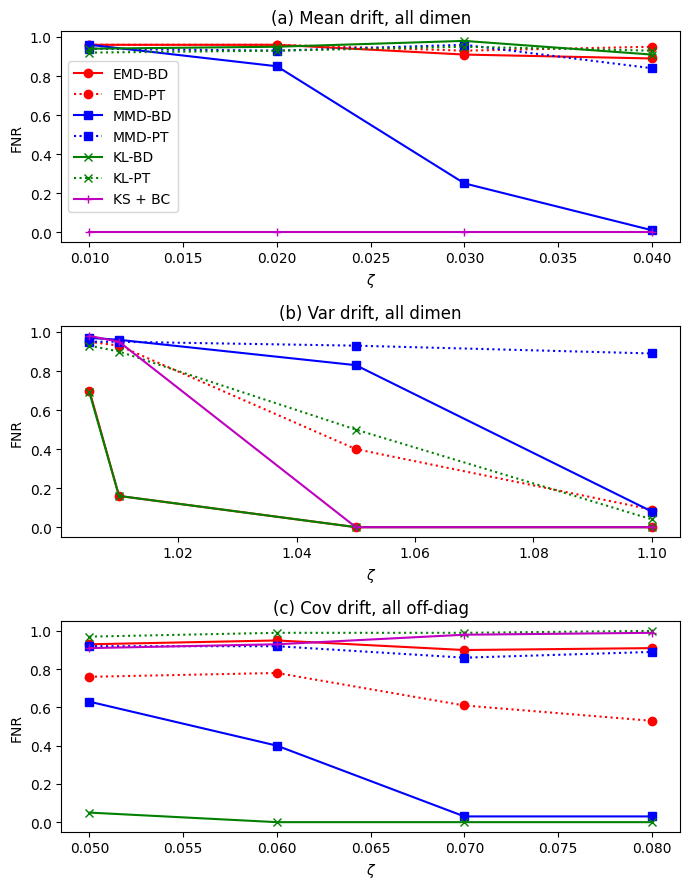

In [1]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 9))

'''Experiment 2b: Mean drift in all dimensions'''
zeta_lst = np.array([0.01, 0.02, 0.03, 0.04])
EMD_BD_FNR_lst = np.array([0.96,0.96,0.91,0.89])
EMD_PT_FNR_lst = np.array([0.96,0.96,0.93,0.95])
MMD_BD_FNR_lst = np.array([0.96,0.85,0.25,0.01])
MMD_PT_FNR_lst = np.array([0.94,0.93,0.96,0.84])
KL_BD_FNR_lst = np.array([0.94,0.95,0.98,0.91])
KL_PT_FNR_lst = np.array([0.92,0.93,0.95,0.93])
KS_BC_FNR_lst = np.array([0,0,0,0])
axes[0].plot(zeta_lst, EMD_BD_FNR_lst, marker='o', c='r', label='EMD-BD')
axes[0].plot(zeta_lst, EMD_PT_FNR_lst, marker='o', c='r', linestyle='dotted', label='EMD-PT')
axes[0].plot(zeta_lst, MMD_BD_FNR_lst, marker='s', c='b', label='MMD-BD')
axes[0].plot(zeta_lst, MMD_PT_FNR_lst, marker='s', c='b', linestyle='dotted', label='MMD-PT')
axes[0].plot(zeta_lst, KL_BD_FNR_lst, marker='x', c='g', label='KL-BD')
axes[0].plot(zeta_lst, KL_PT_FNR_lst, marker='x', c='g', linestyle='dotted', label='KL-PT')
axes[0].plot(zeta_lst, KS_BC_FNR_lst, marker='+', c='m', label='KS + BC')
axes[0].set_title("(a) Mean drift, all dimen")
axes[0].legend(loc="best")
axes[0].set(xlabel=r'$\zeta$', ylabel='FNR')

'''Experiment 3b: Variance drift in all dimensions'''
zeta_lst = np.array([1.005, 1.01, 1.05, 1.10])
EMD_BD_FNR_lst = np.array([0.7,0.16,0,0])
EMD_PT_FNR_lst = np.array([0.95,0.93,0.4,0.09])
MMD_BD_FNR_lst = np.array([0.97,0.96,0.83,0.08])
MMD_PT_FNR_lst = np.array([0.95,0.95,0.93,0.89])
KL_BD_FNR_lst = np.array([0.69,0.16,0,0])
KL_PT_FNR_lst = np.array([0.93,0.9,0.5,0.04])
KS_BC_FNR_lst = np.array([0.98,0.95,0,0])
axes[1].plot(zeta_lst, EMD_BD_FNR_lst, marker='o', c='r', label='EMD-BD')
axes[1].plot(zeta_lst, EMD_PT_FNR_lst, marker='o', c='r', linestyle='dotted', label='EMD-PT')
axes[1].plot(zeta_lst, MMD_BD_FNR_lst, marker='s', c='b', label='MMD-BD')
axes[1].plot(zeta_lst, MMD_PT_FNR_lst, marker='s', c='b', linestyle='dotted', label='MMD-PT')
axes[1].plot(zeta_lst, KL_BD_FNR_lst, marker='x', c='g', label='KL-BD')
axes[1].plot(zeta_lst, KL_PT_FNR_lst, marker='x', c='g', linestyle='dotted', label='KL-PT')
axes[1].plot(zeta_lst, KS_BC_FNR_lst, marker='+', c='m', label='KS + BC')
axes[1].set_title("(b) Var drift, all dimen")
axes[1].set(xlabel=r'$\zeta$', ylabel='FNR')

'''Experiment 4: Covariance drift in all off-diagonals'''
zeta_lst = np.array([0.05, 0.06, 0.07, 0.08])
EMD_BD_FNR_lst = np.array([0.93,0.95,0.9,0.91])
EMD_PT_FNR_lst = np.array([0.76,0.78,0.61,0.53])
MMD_BD_FNR_lst = np.array([0.63,0.4,0.03,0.03])
MMD_PT_FNR_lst = np.array([0.92,0.92,0.86,0.89])
KL_BD_FNR_lst = np.array([0.05,0,0,0])
KL_PT_FNR_lst = np.array([0.97,0.99,0.99,1])
KS_BC_FNR_lst = np.array([0.91,0.93,0.98,0.99])
axes[2].plot(zeta_lst, EMD_BD_FNR_lst, marker='o', c='r', label='EMD-BD')
axes[2].plot(zeta_lst, EMD_PT_FNR_lst, marker='o', c='r', linestyle='dotted', label='EMD-PT')
axes[2].plot(zeta_lst, MMD_BD_FNR_lst, marker='s', c='b', label='MMD-BD')
axes[2].plot(zeta_lst, MMD_PT_FNR_lst, marker='s', c='b', linestyle='dotted', label='MMD-PT')
axes[2].plot(zeta_lst, KL_BD_FNR_lst, marker='x', c='g', label='KL-BD')
axes[2].plot(zeta_lst, KL_PT_FNR_lst, marker='x', c='g', linestyle='dotted', label='KL-PT')
axes[2].plot(zeta_lst, KS_BC_FNR_lst, marker='+', c='m', label='KS + BC')
axes[2].set_title("(c) Cov drift, all off-diag")
axes[2].set(xlabel=r'$\zeta$', ylabel='FNR')

fig.tight_layout() 

### Experiments for Section V
- Here we train classifier models for drift detection.

In [ ]:
import numpy as np
from scipy.stats import wasserstein_distance_nd
from scipy.stats import ttest_rel
from scipy.stats import ks_2samp
from sklearn.metrics import pairwise_kernels
from sklearn.metrics import pairwise_distances
from kernel_2sample_test import *
from KL_div import *

def prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size):
    # size = (set_size, dimension)
    train_set = np.random.multivariate_normal(ref_mean, ref_cov, size)
    ref_set = np.random.multivariate_normal(ref_mean, ref_cov, size)
    det_set = np.random.multivariate_normal(det_mean, det_cov, size)
    return [train_set, ref_set, det_set]

def MMD_mul_D(set1, set2):
    len1 = len(set1)
    len2 = len(set2)
    combined_set = np.vstack([set1, set2])
    sigma2 = np.median(pairwise_distances(set1, set2, metric='euclidean'))**2
    K = pairwise_kernels(combined_set, metric="rbf", gamma=1.0/(2*sigma2))
    return MMD2u(K, len1, len2)

def batch_dist(train_set, ref_set, det_set, batch_num, dist):
    '''
    Returns whether there is a concept drift; True or False.
    '''
    train_batches = np.array_split(train_set, batch_num)
    ref_batches = np.array_split(ref_set, batch_num)
    det_batches = np.array_split(det_set, batch_num)
    train_ref_distances = np.zeros(batch_num)
    train_det_distances = np.zeros(batch_num)
    for i in range(batch_num):
        train_batch = train_batches[i]
        ref_batch = ref_batches[i]
        det_batch = det_batches[i]
        if dist == "EMD":
            train_ref_distances[i] = wasserstein_distance_nd(train_batch, ref_batch)
            train_det_distances[i] = wasserstein_distance_nd(train_batch, det_batch)
        elif dist == "MMD":
            train_ref_distances[i] = MMD_mul_D(train_batch, ref_batch)
            train_det_distances[i] = MMD_mul_D(train_batch, det_batch)
        elif dist == "KL":
            train_ref_distances[i] = KLdivergence(train_batch, ref_batch)
            train_det_distances[i] = KLdivergence(train_batch, det_batch)
    stat, p_val = ttest_rel(train_ref_distances, train_det_distances)
    print(dist + " BD p_val", p_val)
    return [stat, p_val]

def KS(train_set, ref_set, det_set):
    '''
    Works only for single dimension.
    Returns whether there is a concept drift in the specified dimension; True or False.
    '''
    non_det_set = np.concatenate((train_set, ref_set), axis=0)
    stat, p_val = ks_2samp(non_det_set, det_set)
    return [stat, p_val]

def KS_BC(train_set, ref_set, det_set):
    '''
    Applies Bonferroni correction.
    '''
    dimen = len(ref_set[0])
    min_p_val = 1
    max_stat = 0
    for dim_i in range(dimen):
        train_set_i = train_set[:, dim_i]
        ref_set_i = ref_set[:, dim_i]
        det_set_i = det_set[:, dim_i]
        stat, p_val = KS(train_set_i, ref_set_i, det_set_i)
        if p_val < min_p_val:
            min_p_val = p_val
        if stat > max_stat:
            max_stat = stat
    print("min_p_val", min_p_val)
    return [max_stat, min_p_val]

In [ ]:
def get_cov(dim, off_diag):
    cov = np.ones((dim,dim)) * off_diag
    np.fill_diagonal(cov, 1)
    return cov

def create_data(data_type, dimen, drift):
    if data_type == "no drift":
        ref_mean = np.zeros(dimen)
        ref_cov = np.eye(dimen)
        det_mean = ref_mean
        det_cov = ref_cov
        size = 5000
        return prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    elif data_type == "mean drift, single dimen":
        ref_mean = np.zeros(dimen)
        ref_cov = np.eye(dimen)
        det_mean = np.zeros(dimen)
        det_mean[dimen-1] = drift
        det_cov = np.eye(dimen)
        size = 5000
        return prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    elif data_type == "mean drift, all dimen":
        ref_mean = np.zeros(dimen)
        ref_cov = np.eye(dimen)
        det_mean = np.ones(dimen) * drift
        det_cov = np.eye(dimen)
        size = 5000
        return prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    elif data_type == "var drift, single dimen":
        ref_mean = np.zeros(dimen)
        ref_cov = np.eye(dimen)
        det_mean = np.zeros(dimen)
        det_cov = np.eye(dimen)
        det_cov[dimen-1][dimen-1] = drift
        size = 5000
        return prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    elif data_type == "var drift, all dimen":
        ref_mean = np.zeros(dimen)
        ref_cov = np.eye(dimen)
        det_mean = np.zeros(dimen)
        det_cov = np.eye(dimen)
        np.fill_diagonal(det_cov, drift)
        size = 5000
        return prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    elif data_type == "cov drift, all off-diag":
        ref_mean = np.zeros(dimen)
        ref_cov = np.eye(dimen)
        det_mean = np.zeros(dimen)
        det_cov = np.eye(dimen)
        det_cov = get_cov(dimen, drift)
        size = 5000
        return prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)

def prepare_prior_data(num_drift_lst, dim, mean_a_lst, var_a_lst, cov_lst):
    '''
    num_drift_lst: list of number of examples for each type of drift
    dim: feature dimension of the data
    mean_s_lst: list of means for the mean drift in single dimension.
    mean_a_lst: list of means for the mean drfit in all dimensions.
    var_s_lst: list of variances for the variance drift in single dimension.
    var_a_lst: list of variances for the variance drift in all dimensions.
    cov_lst: list of covariances for the covariance drift for all off-diagonals.
    ---
    output: list containing lists of numpy arrays.
    ---
    Outputs a total of (num_nodrift + num_drift) data quadruplets.
    Each quadruplets contains (1) a train set, (2) a reference set, 
    (3) a detection set, and (4) the presence of drift.
    '''
    num_no_dft = num_drift_lst[0]
    num_mean_dft_a = num_drift_lst[1]
    num_var_dft_a = num_drift_lst[2]
    num_cov_dft = num_drift_lst[3]
    drift_lst_len = len(mean_a_lst)
    data = []
    for i in range(num_no_dft):
        got_drift = 0
        drift = 0
        train_set, ref_set, det_set = create_data("no drift", dim, drift)
        data.append([train_set, ref_set, det_set, got_drift])
    for i in range(num_mean_dft_a):
        got_drift = 1
        drift = mean_a_lst[i % drift_lst_len]
        train_set, ref_set, det_set = create_data("mean drift, all dimen", dim, drift)
        data.append([train_set, ref_set, det_set, got_drift])
    for i in range(num_var_dft_a):
        got_drift = 1
        drift = var_a_lst[i % drift_lst_len]
        train_set, ref_set, det_set = create_data("var drift, all dimen", dim, drift)
        data.append([train_set, ref_set, det_set, got_drift])
    for i in range(num_cov_dft):
        got_drift = 1
        drift = cov_lst[i % drift_lst_len]
        train_set, ref_set, det_set = create_data("cov drift, all off-diag", dim, drift)
        data.append([train_set, ref_set, det_set, got_drift])
    return data

def get_classifier_data(data, batch_num):
    '''
    data: a list of (train_set, ref_set, det_set, got_drift)
    train_set: a 2D numpy array
    ref_set: a 2D numpy array
    det_set: a 2D numpy array
    got_drift; {0, 1}
    ---
    output: list of [features, observations]
    features: 2D numpy array
    observations: 1D numpy array
    '''
    num_features = 4
    num_data = len(data)
    features_pval = np.zeros((num_data, num_features))
    features_stat = np.zeros((num_data, num_features))
    observations = np.zeros(num_data)
    for i in range(num_data):
        print("... classifier data index:", i)
        train_set, ref_set, det_set, got_drift = data[i]
        stat_BD_EMD, p_val_BD_EMD = batch_dist(train_set, ref_set, det_set, batch_num, "EMD")
        stat_BD_MMD, p_val_BD_MMD = batch_dist(train_set, ref_set, det_set, batch_num, "MMD")
        stat_BD_KL, p_val_BD_KL = batch_dist(train_set, ref_set, det_set, batch_num, "KL")
        stat_KS_BC, p_val_KS_BC = KS_BC(train_set, ref_set, det_set) # min p-val
        features_pval[i, :] = np.array([p_val_BD_EMD, p_val_BD_MMD, p_val_BD_KL, p_val_KS_BC])
        features_stat[i, :] = np.array([stat_BD_EMD, stat_BD_MMD, stat_BD_KL, stat_KS_BC])
        observations[i] = got_drift
    return [features_pval, features_stat, observations]

### Following code is to produce synthetic training data for the classifiers

In [ ]:
np.random.seed(1) # Different data from experiments will be generated for training.

num_drift_lst = [50, 40, 40, 40]
dim = 100
mean_a_lst = [0.01, 0.02, 0.03, 0.04]
var_a_lst = [1.005, 1.01, 1.05, 1.10]
cov_lst = [0.05, 0.06, 0.07, 0.08]
data = prepare_prior_data(num_drift_lst, dim, mean_a_lst, var_a_lst, cov_lst)
print("... preparing prior data completed.")
batch_num = 50
features_pval, features_stat, obs = get_classifier_data(data, batch_num)
print("features_pval\n", features_pval)
print("features_stat\n", features_stat)
print("observations\n", obs)
np.save("train_feat_pval.npy", features_pval)
np.save("train_feat_stat.npy", features_stat)
np.save("train_obs.npy", obs)

### We generate all the test statistics and p-values required for our experiments
- Experiments: No drift, Mean drift in all dimensions, Variance drift in all dimensions, Covariance drift -- all off-diagonals
- Approaches: BD with EMD, BD with MMD, BD with KL, KS + BC

In [ ]:
''' Experiment 1: No drift'''
np.random.seed(0)
num_sim = 100
batch_num = 50
batch_size = 100
p_val_data = np.zeros((100, 4))
stat_data = np.zeros((100, 4))
for sim_i in range(num_sim):
    print("...Simulation:", sim_i+1)
    ref_mean = np.zeros(100)
    ref_cov = np.eye(100)
    det_mean = np.zeros(100)
    det_cov = np.eye(100)
    size = batch_num * batch_size
    train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    stat_EMD, p_val_BD_EMD = batch_dist(train_set, ref_set, det_set, batch_num, "EMD")
    stat_MMD, p_val_BD_MMD = batch_dist(train_set, ref_set, det_set, batch_num, "MMD")
    stat_KL, p_val_BD_KL = batch_dist(train_set, ref_set, det_set, batch_num, "KL")
    stat_KS_BC, p_val_KS_BC = KS_BC(train_set, ref_set, det_set)
    p_vals = np.array([p_val_BD_EMD, p_val_BD_MMD, p_val_BD_KL, p_val_KS_BC])
    stats = np.array([stat_EMD, stat_MMD, stat_KL, stat_KS_BC])
    p_val_data[sim_i, :] = p_vals
    stat_data[sim_i, :] = stats
np.save("p_val_no_drift.npy", p_val_data)
np.save("stat_no_drift.npy", stat_data)

### The following code is for the `no drift' experiment

In [ ]:
np.random.seed(0)
num_sim = 100
batch_num = 50
batch_size = 100
p_val_data = np.zeros((100, 4))
stat_data = np.zeros((100, 4))
for sim_i in range(num_sim):
    print("...Simulation:", sim_i+1)
    ref_mean = np.zeros(100)
    ref_cov = np.eye(100)
    det_mean = np.zeros(100)
    det_cov = np.eye(100)
    size = batch_num * batch_size
    train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
    stat_EMD, p_val_BD_EMD = batch_dist(train_set, ref_set, det_set, batch_num, "EMD")
    stat_MMD, p_val_BD_MMD = batch_dist(train_set, ref_set, det_set, batch_num, "MMD")
    stat_KL, p_val_BD_KL = batch_dist(train_set, ref_set, det_set, batch_num, "KL")
    stat_KS_BC, p_val_KS_BC = KS_BC(train_set, ref_set, det_set)
    p_vals = np.array([p_val_BD_EMD, p_val_BD_MMD, p_val_BD_KL, p_val_KS_BC])
    stats = np.array([stat_EMD, stat_MMD, stat_KL, stat_KS_BC])
    p_val_data[sim_i, :] = p_vals
    stat_data[sim_i, :] = stats
np.save("p_val_no_drift.npy", p_val_data)
np.save("stat_no_drift.npy", stat_data)

### The following code is for the 'mean drift in all feature dimensions' experiment

In [ ]:
np.random.seed(0)
num_sim = 100
batch_num = 50
batch_size = 100
mean_lst = [0.01,0.02,0.03,0.04]
p_val_data = np.zeros((4, 100, 4))
stat_data = np.zeros((4, 100, 4))
for idx in range(len(mean_lst)):
    print(" ---> current mean:", mean_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.ones(100) * mean_lst[idx]
        det_cov = np.eye(100)
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        stat_EMD, p_val_BD_EMD = batch_dist(train_set, ref_set, det_set, batch_num, "EMD")
        stat_MMD, p_val_BD_MMD = batch_dist(train_set, ref_set, det_set, batch_num, "MMD")
        stat_KL, p_val_BD_KL = batch_dist(train_set, ref_set, det_set, batch_num, "KL")
        stat_KS_BC, p_val_KS_BC = KS_BC(train_set, ref_set, det_set)
        p_vals = np.array([p_val_BD_EMD, p_val_BD_MMD, p_val_BD_KL, p_val_KS_BC])
        stats = np.array([stat_EMD, stat_MMD, stat_KL, stat_KS_BC])
        p_val_data[idx, sim_i, :] = p_vals
        stat_data[idx, sim_i, :] = stats
np.save("p_val_mean_drift.npy", p_val_data)
np.save("stat_mean_drift.npy", stat_data)

### The following code is for the 'variance drift in all feature dimensions' experiment

In [ ]:
np.random.seed(0)
num_sim = 100
batch_num = 50
batch_size = 100
sig_lvl = 0.05
var_lst = [1.005,1.01,1.05,1.10]
p_val_data = np.zeros((4, 100, 4))
stat_data = np.zeros((4, 100, 4))
for idx in range(len(var_lst)):
    print(" ---> current mean:", var_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        np.fill_diagonal(det_cov, var_lst[idx])
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        stat_EMD, p_val_BD_EMD = batch_dist(train_set, ref_set, det_set, batch_num, "EMD")
        stat_MMD, p_val_BD_MMD = batch_dist(train_set, ref_set, det_set, batch_num, "MMD")
        stat_KL, p_val_BD_KL = batch_dist(train_set, ref_set, det_set, batch_num, "KL")
        stat_KS_BC, p_val_KS_BC = KS_BC(train_set, ref_set, det_set)
        p_vals = np.array([p_val_BD_EMD, p_val_BD_MMD, p_val_BD_KL, p_val_KS_BC])
        stats = np.array([stat_EMD, stat_MMD, stat_KL, stat_KS_BC])
        p_val_data[idx, sim_i, :] = p_vals
        stat_data[idx, sim_i, :] = stats
np.save("p_val_var_drift.npy", p_val_data) 
np.save("stat_var_drift.npy", stat_data) 

### The following code is for the 'covariance drift, all off-diagonals' experiment

In [ ]:
def get_cov(dim, off_diag):
    cov = np.ones((dim,dim)) * off_diag
    np.fill_diagonal(cov, 1)
    return cov

np.random.seed(0)
num_sim = 100
batch_num = 50
batch_size = 100
sig_lvl = 0.05
off_diag_lst = [0.05,0.06,0.07,0.08]
p_val_data = np.zeros((4, 100, 4))
for idx in range(len(off_diag_lst)):
    print(" ---> current mean:", off_diag_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        ref_mean = np.zeros(100)
        ref_cov = np.eye(100)
        det_mean = np.zeros(100)
        det_cov = np.eye(100)
        det_cov = get_cov(100, off_diag_lst[idx])
        size = batch_num * batch_size
        train_set, ref_set, det_set = prepare_data_multi_D(ref_mean, ref_cov, det_mean, det_cov, size)
        stat_EMD, p_val_BD_EMD = batch_dist(train_set, ref_set, det_set, batch_num, "EMD")
        stat_MMD, p_val_BD_MMD = batch_dist(train_set, ref_set, det_set, batch_num, "MMD")
        stat_KL, p_val_BD_KL = batch_dist(train_set, ref_set, det_set, batch_num, "KL")
        stat_KS_BC, p_val_KS_BC = KS_BC(train_set, ref_set, det_set)
        p_vals = np.array([p_val_BD_EMD, p_val_BD_MMD, p_val_BD_KL, p_val_KS_BC])
        stats = np.array([stat_EMD, stat_MMD, stat_KL, stat_KS_BC])
        p_val_data[idx, sim_i, :] = p_vals
        stat_data[idx, sim_i, :] = stats
np.save("p_val_cov_drift.npy", p_val_data) 
np.save("stat_cov_drift.npy", stat_data) 

### We study the following approaches:
- AVG: average p-value approach
- PL: perceptron learning approach
- LR-p: logistic regression in Algorithm 3 of the paper, using p-values as features
- kNN-p: k-nearest neighbour in Algorithm 3 of the paper, using p-values as features
- MLP-p: multi-layer perceptron in Algorithm 3 of the paper, using p-values as features
- LR-s: logistic regression in Algorithm 3 of the paper, using test statistics as features
- kNN-s: k-nearest neighbour in Algorithm 3 of the paper, using test statistics as features
- MLP-s: multi-layer perceptron in Algorithm 3 of the paper, using test statistics as features

### The following code is for AVG

In [ ]:
'''No drift'''
p_val_data = np.load("p_val_no_drift.npy")
num_sim = len(p_val_data)
sig_lvl = 0.05
FPR = 0
for sim_i in range(num_sim):
    feature = p_val_data[sim_i]
    avg_p_val = feature.mean()
    print("avg_p_val", avg_p_val)
    got_drift = 0 # 0 means no drift, 1 means got drift
    if avg_p_val < sig_lvl:
        got_drift = 1
    if got_drift == 1:
        FPR += 1
FPR = FPR / num_sim
print("FPR", FPR)
print("FNR", 0)
# FPR 0.0
# FNR 0

In [ ]:
'''Mean drift in all dimensions'''
mean_lst = [0.01,0.02,0.03,0.04]
p_val_data = np.load("p_val_mean_drift.npy")
num_sim = len(p_val_data)
FNR = np.zeros(len(mean_lst))
for idx in range(len(mean_lst)):
    print(" ---> current mean:", mean_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        avg_p_val = feature.mean()
        print("avg_p_val", avg_p_val)
        got_drift = 0 # 0 means no drift, 1 means got drift
        if avg_p_val < sig_lvl:
            got_drift = 1
        if got_drift == 0:
            FNR[idx] += 1
FNR = FNR / num_sim
print("FPR", 0)
print("FNR", FNR)
# FPR 0
# FNR [1.   1.   1.   0.75]

In [ ]:
'''Variance drift in all dimensions'''
var_lst = [1.005,1.01,1.05,1.10]
p_val_data = np.load("p_val_var_drift.npy")
num_sim = len(p_val_data)
FNR = np.zeros(len(mean_lst))
for idx in range(len(var_lst)):
    print(" ---> current mean:", var_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        avg_p_val = feature.mean()
        print("avg_p_val", avg_p_val)
        got_drift = 0 # 0 means no drift, 1 means got drift
        if avg_p_val < sig_lvl:
            got_drift = 1
        if got_drift == 0:
            FNR[idx] += 1
FNR = FNR / num_sim
print("FPR", 0)
print("FNR", FNR)
# FPR 0
# FNR [1. 1. 1. 0.]

In [ ]:
'''Covariance drift in all off-diagonals'''
off_diag_lst = [0.05,0.06,0.07,0.08]
p_val_data = np.load("p_val_cov_drift.npy")
num_sim = len(p_val_data)
FNR = np.zeros(len(mean_lst))
for idx in range(len(off_diag_lst)):
    print(" ---> current mean:", off_diag_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        avg_p_val = feature.mean()
        print("avg_p_val", avg_p_val)
        got_drift = 0 # 0 means no drift, 1 means got drift
        if avg_p_val < sig_lvl:
            got_drift = 1
        if got_drift == 0:
            FNR[idx] += 1
FNR = FNR / num_sim
print("FPR", 0)
print("FNR", FNR)
# FPR 0
# FNR [0.75 1.   1.   0.5 ]

### The following code is for PL

In [ ]:
train_feat_pval = np.load("train_feat_pval.npy")
train_obs = np.load("train_obs.npy")

from sklearn.linear_model import Perceptron

Percep = Perceptron(fit_intercept=False)
sig_lvl = 0.05
Percep.fit(train_feat_pval, train_obs, intercept_init=sig_lvl)
print("Percep.coef", Percep.coef_)
print("Percep.intercept", Percep.intercept_)
# Percep.coef [[ 0.13448345 -0.28214584 -0.36363406 -0.96341305]]
# Percep.intercept [0.05]

Percep.coef [[ 0.13448345 -0.28214584 -0.36363406 -0.96341305]]
Percep.intercept [0.05]


In [ ]:
p_val_data = np.load("p_val_no_drift.npy")
print(p_val_data)

In [ ]:
'''No drift'''
p_val_data = np.load("p_val_no_drift.npy")
num_sim = len(p_val_data)
FPR = 0
for sim_i in range(num_sim):
    feature = p_val_data[sim_i]
    feature = np.array([feature,])
    got_drift = Percep.predict(feature)
    print("got_drift", got_drift)
    if got_drift == 1:
        FPR += 1
FPR = FPR / num_sim
print("FPR", FPR)
print("FNR", 0)
# FPR 0.02
# FNR 0

In [ ]:
'''Mean drift in all dimensions'''
mean_lst = [0.01,0.02,0.03,0.04]
p_val_data = np.load("p_val_mean_drift.npy")
num_sim = len(p_val_data)
FNR = np.zeros(len(mean_lst))
for idx in range(len(mean_lst)):
    print(" ---> current mean:", mean_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = np.array([feature,])
        got_drift = Percep.predict(feature)
        print("got_drift", got_drift)
        if got_drift == 0:
            FNR[idx] += 1
FNR = FNR / num_sim
print("FPR", 0)
print("FNR", FNR)
# FPR 0
# FNR [0.75 1.   1.   0.75]

In [ ]:
'''Variance drift in all dimensions'''
var_lst = [1.005,1.01,1.05,1.10]
p_val_data = np.load("p_val_var_drift.npy")
num_sim = len(p_val_data)
FNR = np.zeros(len(var_lst))
for idx in range(len(var_lst)):
    print(" ---> current mean:", var_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = np.array([feature,])
        got_drift = Percep.predict(feature)
        print("got_drift", got_drift)
        if got_drift == 0:
            FNR[idx] += 1
FNR = FNR / num_sim
print("FPR", 0)
print("FNR", FNR)
# FPR 0
# FNR [0.75 0.75 1.   0.  ]

In [ ]:
'''Covariance drift in all off-diagonals'''
off_diag_lst = [0.05,0.06,0.07,0.08]
p_val_data = np.load("p_val_cov_drift.npy")
num_sim = len(p_val_data)
FNR = np.zeros(len(off_diag_lst))
for idx in range(len(off_diag_lst)):
    print(" ---> current mean:", off_diag_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = np.array([feature,])
        got_drift = Percep.predict(feature)
        print("got_drift", got_drift)
        if got_drift == 0:
            FNR[idx] += 1
FNR = FNR / num_sim
print("FPR", 0)
print("FNR", FNR)
# FPR 0
# FNR [0.5  0.   0.25 0.  ]

### The following code is for LR-p, kNN-p, MLP-p

In [ ]:
train_feat_pval = np.load("train_feat_pval.npy")
train_obs = np.load("train_obs.npy")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
train_feat_pval = scaler.fit_transform(train_feat_pval)
LR_pval = LogisticRegression()
LR_pval.fit(train_feat_pval, train_obs)
kN_pval = KNeighborsClassifier(n_neighbors=10)
kN_pval.fit(train_feat_pval, train_obs)
MLP_pval = MLPClassifier(hidden_layer_sizes=(4,2), max_iter=1000, activation='relu', solver='adam')
MLP_pval.fit(train_feat_pval, train_obs)

In [ ]:
'''No drift'''
p_val_data = np.load("p_val_no_drift.npy")
FPR_LR = 0
FPR_kN = 0
FPR_MLP = 0
for sim_i in range(num_sim):
    feature = p_val_data[sim_i]
    feature = scaler.transform(np.array([feature,]))
    prob_LR = LR_pval.predict_proba(feature)[0][1]
    prob_kN = kN_pval.predict_proba(feature)[0][1]
    prob_MLP = MLP_pval.predict_proba(feature)[0][1]
    print("prob_LR", prob_LR)
    print("prob_kN", prob_kN)
    print("prob_MLP", prob_MLP)
    got_drift_LR = 0 # 0 means no drift, 1 means got drift
    got_drift_kN = 0
    got_drift_MLP = 0
    if prob_LR >= 0.8:
        got_drift_LR = 1
    if prob_kN >= 0.85:
        got_drift_kN = 1
    if prob_MLP >= 0.8:
        got_drift_MLP = 1
    if got_drift_LR == 1:
        FPR_LR += 1
    if got_drift_kN == 1:
        FPR_kN += 1
    if got_drift_MLP == 1:
        FPR_MLP += 1
FPR_LR = FPR_LR / num_sim
FPR_kN = FPR_kN / num_sim
FPR_MLP = FPR_MLP / num_sim
print("FPR_LR", FPR_LR)
print("FNR_LR", 0)
print("FPR_kN", FPR_kN)
print("FNR_kN", 0)
print("FPR_MLP", FPR_MLP)
print("FPR_MLP", 0)
'''Using LR threshold of 0.8, kN threshold 0.85, MLP threshold 0.8'''
# FPR_LR 0.09
# FNR_LR 0
# FPR_kN 0.06
# FNR_kN 0
# FPR_MLP 0.09
# FPR_MLP 0

In [ ]:
'''Mean drift in all dimensions'''
mean_lst = [0.01,0.02,0.03,0.04]
p_val_data = np.load("p_val_mean_drift.npy")
FNR_LR = np.zeros(len(mean_lst))
FNR_kN = np.zeros(len(mean_lst))
FNR_MLP = np.zeros(len(mean_lst))
for idx in range(len(mean_lst)):
    print(" ---> current mean:", mean_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = scaler.transform(np.array([feature,]))
        prob_LR = LR_pval.predict_proba(feature)[0][1]
        prob_kN = kN_pval.predict_proba(feature)[0][1]
        prob_MLP = MLP_pval.predict_proba(feature)[0][1]
        print("prob_LR", prob_LR)
        print("prob_kN", prob_kN)
        print("prob_MLP", prob_MLP)
        got_drift_LR = 0 # 0 means no drift, 1 means got drift
        got_drift_kN = 0
        got_drift_MLP = 0
        if prob_LR >= 0.8:
            got_drift_LR = 1
        if prob_kN >= 0.85:
            got_drift_kN = 1
        if prob_MLP >= 0.8:
            got_drift_MLP = 1
        if got_drift_LR == 0:
            FNR_LR[idx] += 1
        if got_drift_kN == 0:
            FNR_kN[idx] += 1
        if got_drift_MLP == 0:
            FNR_MLP[idx] += 1
FNR_LR = FNR_LR / num_sim
FNR_kN = FNR_kN / num_sim
FNR_MLP = FNR_MLP / num_sim
print("FPR_LR", 0)
print("FNR_LR", FNR_LR)
print("FPR_kN", 0)
print("FNR_kN", FNR_kN)
print("FPR_MLP", 0)
print("FNR_MLP", FNR_MLP)
'''Using LR threshold of 0.8, kN threshold 0.85, MLP threshold 0.8'''
# FPR_LR 0
# FNR_LR [0.82 0.62 0.41 0.21]
# FPR_kN 0
# FNR_kN [0.89 0.73 0.61 0.48]
# FPR_MLP 0
# FNR_MLP [0.76 0.57 0.46 0.35]

In [ ]:
'''Variance drift in all dimensions'''
var_lst = [1.005,1.01,1.05,1.10]
p_val_data = np.load("p_val_var_drift.npy")
FNR_LR = np.zeros(len(mean_lst))
FNR_kN = np.zeros(len(mean_lst))
FNR_MLP = np.zeros(len(mean_lst))
for idx in range(len(var_lst)):
    print(" ---> current mean:", var_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = scaler.transform(np.array([feature,]))
        prob_LR = LR_pval.predict_proba(feature)[0][1]
        prob_kN = kN_pval.predict_proba(feature)[0][1]
        prob_MLP = MLP_pval.predict_proba(feature)[0][1]
        print("prob_LR", prob_LR)
        print("prob_kN", prob_kN)
        print("prob_MLP", prob_MLP)
        got_drift_LR = 0 # 0 means no drift, 1 means got drift
        got_drift_kN = 0
        got_drift_MLP = 0
        if prob_LR >= 0.8:
            got_drift_LR = 1
        if prob_kN >= 0.85:
            got_drift_kN = 1
        if prob_MLP >= 0.8:
            got_drift_MLP = 1
        if got_drift_LR == 0:
            FNR_LR[idx] += 1
        if got_drift_kN == 0:
            FNR_kN[idx] += 1
        if got_drift_MLP == 0:
            FNR_MLP[idx] += 1
FNR_LR = FNR_LR / num_sim
FNR_kN = FNR_kN / num_sim
FNR_MLP = FNR_MLP / num_sim
print("FPR_LR", 0)
print("FNR_LR", FNR_LR)
print("FPR_kN", 0)
print("FNR_kN", FNR_kN)
print("FPR_MLP", 0)
print("FNR_MLP", FNR_MLP)
'''Using LR threshold of 0.8, kN threshold 0.85, MLP threshold 0.8'''
# FPR_LR 0
# FNR_LR [0.8  0.62 0.29 0.04]
# FPR_kN 0
# FNR_kN [0.88 0.64 0.25 0.04]
# FPR_MLP 0
# FNR_MLP [0.68 0.34 0.06 0.02]

In [ ]:
'''Covariance drift, all off-diagonals'''
off_diag_lst = [0.05,0.06,0.07,0.08]
p_val_data = np.load("p_val_cov_drift.npy")
FNR_LR = np.zeros(len(mean_lst))
FNR_kN = np.zeros(len(mean_lst))
FNR_MLP = np.zeros(len(mean_lst))
for idx in range(len(off_diag_lst)):
    print(" ---> current mean:", off_diag_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = scaler.transform(np.array([feature,]))
        prob_LR = LR_pval.predict_proba(feature)[0][1]
        prob_kN = kN_pval.predict_proba(feature)[0][1]
        prob_MLP = MLP_pval.predict_proba(feature)[0][1]
        print("prob_LR", prob_LR)
        print("prob_kN", prob_kN)
        print("prob_MLP", prob_MLP)
        got_drift_LR = 0 # 0 means no drift, 1 means got drift
        got_drift_kN = 0
        got_drift_MLP = 0
        if prob_LR >= 0.8:
            got_drift_LR = 1
        if prob_kN >= 0.85:
            got_drift_kN = 1
        if prob_MLP >= 0.8:
            got_drift_MLP = 1
        if got_drift_LR == 0:
            FNR_LR[idx] += 1
        if got_drift_kN == 0:
            FNR_kN[idx] += 1
        if got_drift_MLP == 0:
            FNR_MLP[idx] += 1
FNR_LR = FNR_LR / num_sim
FNR_kN = FNR_kN / num_sim
FNR_MLP = FNR_MLP / num_sim
print("FPR_LR", 0)
print("FNR_LR", FNR_LR)
print("FPR_kN", 0)
print("FNR_kN", FNR_kN)
print("FPR_MLP", 0)
print("FNR_MLP", FNR_MLP)
'''Using LR threshold of 0.8, kN threshold 0.85, MLP threshold 0.8'''
# FNR_LR [0.36 0.26 0.05 0.11]
# FPR_kN 0
# FNR_kN [0.47 0.31 0.14 0.14]
# FPR_MLP 0
# FNR_MLP [0.24 0.12 0.01 0.02]

### The following code is for LR-s, kNN-s, MLP-s

In [ ]:
train_feat_stat = np.load("train_feat_stat.npy")
train_obs = np.load("train_obs.npy")

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

scaler = StandardScaler()
train_feat_pval = scaler.fit_transform(train_feat_stat)
LR_pval = LogisticRegression()
LR_pval.fit(train_feat_pval, train_obs)
kN_pval = KNeighborsClassifier(n_neighbors=10)
kN_pval.fit(train_feat_pval, train_obs)
MLP_pval = MLPClassifier(hidden_layer_sizes=(4,2), max_iter=1000, activation='relu', solver='adam')
MLP_pval.fit(train_feat_pval, train_obs)

In [ ]:
'''No drift'''
stat_data = np.load("stat_no_drift.npy")
FPR_LR = 0
FPR_kN = 0
FPR_MLP = 0
for sim_i in range(num_sim):
    feature = stat_data[sim_i]
    feature = scaler.transform(np.array([feature,]))
    prob_LR = LR_pval.predict_proba(feature)[0][1]
    prob_kN = kN_pval.predict_proba(feature)[0][1]
    prob_MLP = MLP_pval.predict_proba(feature)[0][1]
    print("prob_LR", prob_LR)
    print("prob_kN", prob_kN)
    print("prob_LR", prob_MLP)
    got_drift_LR = 0 # 0 means no drift, 1 means got drift
    got_drift_kN = 0
    got_drift_MLP = 0
    if prob_LR >= 0.8:
        got_drift_LR = 1
    if prob_kN >= 0.85:
        got_drift_kN = 1
    if prob_MLP >= 0.8:
        got_drift_MLP = 1
    if got_drift_LR == 1:
        FPR_LR += 1
    if got_drift_kN == 1:
        FPR_kN += 1
    if got_drift_MLP == 1:
        FPR_MLP += 1
FPR_LR = FPR_LR / num_sim
FPR_kN = FPR_kN / num_sim
FPR_MLP = FPR_MLP / num_sim
print("FPR_LR", FPR_LR)
print("FNR_LR", 0)
print("FPR_kN", FPR_kN)
print("FNR_kN", 0)
print("FPR_MLP", FPR_MLP)
print("FPR_MLP", 0)
'''Using LR threshold of 0.8, kN threshold 0.85, MLP threshold 0.8'''
# FPR_LR 0.05
# FNR_LR 0
# FPR_kN 0.07
# FNR_kN 0
# FPR_MLP 0.06
# FPR_MLP 0

In [ ]:
'''Mean drift in all dimensions'''
mean_lst = [0.01,0.02,0.03,0.04]
p_val_data = np.load("stat_mean_drift.npy")
FNR_LR = np.zeros(len(mean_lst))
FNR_kN = np.zeros(len(mean_lst))
FNR_MLP = np.zeros(len(mean_lst))
for idx in range(len(mean_lst)):
    print(" ---> current mean:", mean_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = scaler.transform(np.array([feature,]))
        prob_LR = LR_pval.predict_proba(feature)[0][1]
        prob_kN = kN_pval.predict_proba(feature)[0][1]
        prob_MLP = MLP_pval.predict_proba(feature)[0][1]
        print("prob_LR", prob_LR)
        print("prob_kN", prob_kN)
        print("prob_MLP", prob_MLP)
        got_drift_LR = 0 # 0 means no drift, 1 means got drift
        got_drift_kN = 0
        got_drift_MLP = 0
        if prob_LR >= 0.8:
            got_drift_LR = 1
        if prob_kN >= 0.85:
            got_drift_kN = 1
        if prob_MLP >= 0.8:
            got_drift_MLP = 1
        if got_drift_LR == 0:
            FNR_LR[idx] += 1
        if got_drift_kN == 0:
            FNR_kN[idx] += 1
        if got_drift_MLP == 0:
            FNR_MLP[idx] += 1
FNR_LR = FNR_LR / num_sim
FNR_kN = FNR_kN / num_sim
FNR_MLP = FNR_MLP / num_sim
print("FPR_LR", 0)
print("FNR_LR", FNR_LR)
print("FPR_kN", 0)
print("FNR_kN", FNR_kN)
print("FPR_MLP", 0)
print("FNR_MLP", FNR_MLP)
'''Using LR threshold of 0.8, kN threshold 0.85, MLP threshold 0.8'''
# FPR_LR 0
# FNR_LR [0.87 0.45 0.1  0.  ]
# FPR_kN 0
# FNR_kN [0.91 0.65 0.2  0.02]
# FPR_MLP 0
# FNR_MLP [0.88 0.51 0.11 0.  ]

In [ ]:
'''Variance drift in all dimensions'''
var_lst = [1.005,1.01,1.05,1.10]
p_val_data = np.load("stat_var_drift.npy")
FNR_LR = np.zeros(len(mean_lst))
FNR_kN = np.zeros(len(mean_lst))
FNR_MLP = np.zeros(len(mean_lst))
for idx in range(len(var_lst)):
    print(" ---> current mean:", var_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = scaler.transform(np.array([feature,]))
        prob_LR = LR_pval.predict_proba(feature)[0][1]
        prob_kN = kN_pval.predict_proba(feature)[0][1]
        prob_MLP = MLP_pval.predict_proba(feature)[0][1]
        print("prob_LR", prob_LR)
        print("prob_kN", prob_kN)
        print("prob_MLP", prob_MLP)
        got_drift_LR = 0 # 0 means no drift, 1 means got drift
        got_drift_kN = 0
        got_drift_MLP = 0
        if prob_LR >= 0.8:
            got_drift_LR = 1
        if prob_kN >= 0.85:
            got_drift_kN = 1
        if prob_MLP >= 0.8:
            got_drift_MLP = 1
        if got_drift_LR == 0:
            FNR_LR[idx] += 1
        if got_drift_kN == 0:
            FNR_kN[idx] += 1
        if got_drift_MLP == 0:
            FNR_MLP[idx] += 1
FNR_LR = FNR_LR / num_sim
FNR_kN = FNR_kN / num_sim
FNR_MLP = FNR_MLP / num_sim
print("FPR_LR", 0)
print("FNR_LR", FNR_LR)
print("FPR_kN", 0)
print("FNR_kN", FNR_kN)
print("FPR_MLP", 0)
print("FNR_MLP", FNR_MLP)
'''Using LR threshold of 0.8, kN threshold 0.85, MLP threshold 0.8'''
# FPR_LR 0
# FNR_LR [0.92 0.88 0.06 0.  ]
# FPR_kN 0
# FNR_kN [0.94 0.91 0.01 0.  ]
# FPR_MLP 0
# FNR_MLP [0.95 0.97 0.33 0.  ]

In [ ]:
'''Covariance drift, all off-diagonals'''
off_diag_lst = [0.05,0.06,0.07,0.08]
p_val_data = np.load("stat_cov_drift.npy")
FNR_LR = np.zeros(len(mean_lst))
FNR_kN = np.zeros(len(mean_lst))
FNR_MLP = np.zeros(len(mean_lst))
for idx in range(len(off_diag_lst)):
    print(" ---> current mean:", off_diag_lst[idx])
    for sim_i in range(num_sim):
        print("...Simulation:", sim_i+1)
        feature = p_val_data[idx][sim_i]
        feature = scaler.transform(np.array([feature,]))
        prob_LR = LR_pval.predict_proba(feature)[0][1]
        prob_kN = kN_pval.predict_proba(feature)[0][1]
        prob_MLP = MLP_pval.predict_proba(feature)[0][1]
        print("prob_LR", prob_LR)
        print("prob_kN", prob_kN)
        print("prob_MLP", prob_MLP)
        got_drift_LR = 0 # 0 means no drift, 1 means got drift
        got_drift_kN = 0
        got_drift_MLP = 0
        if prob_LR >= 0.8:
            got_drift_LR = 1
        if prob_kN >= 0.85:
            got_drift_kN = 1
        if prob_MLP >= 0.8:
            got_drift_MLP = 1
        if got_drift_LR == 0:
            FNR_LR[idx] += 1
        if got_drift_kN == 0:
            FNR_kN[idx] += 1
        if got_drift_MLP == 0:
            FNR_MLP[idx] += 1
FNR_LR = FNR_LR / num_sim
FNR_kN = FNR_kN / num_sim
FNR_MLP = FNR_MLP / num_sim
print("FPR_LR", 0)
print("FNR_LR", FNR_LR)
print("FPR_kN", 0)
print("FNR_kN", FNR_kN)
print("FPR_MLP", 0)
print("FNR_MLP", FNR_MLP)
'''Using LR threshold of 0.8, kN threshold 0.85, MLP threshold 0.8'''
# FPR_LR 0
# FNR_LR [0.52 0.27 0.06 0.01]
# FPR_kN 0
# FNR_kN [0.57 0.28 0.06 0.02]
# FPR_MLP 0
# FNR_MLP [0.67 0.36 0.12 0.05]

### Computing overall accuracy

In [ ]:
acc = ((100-7)+(100-93)+(100-93)+(100-93)+(100-97)+(100-69)+(100-16)+(100-0)+(100-0)+(100-94)+(100-94)+(100-95)+(100-94)) / (13*100)
print("EMD acc", acc)

acc = ((100-7)+(100-92)+(100-88)+(100-52)+(100-17)+(100-93)+(100-93)+(100-85)+(100-40)+(100-79)+(100-55)+(100-37)+(100-23)) / (13*100)
print("MMD acc",acc)

acc = ((100-4)+(100-96)+(100-98)+(100-97)+(100-93)+(100-82)+(100-46)+(100-0)+(100-0)+(100-30)+(100-6)+(100-0)+(100-0)) / (13*100)
print("KL acc",acc)

acc = ((100-6)+(100-91)+(100-48)+(100-13)+(100-0)+(100-94)+(100-98)+(100-88)+(100-53)+(100-95)+(100-95)+(100-95)+(100-95)) / (13*100)
print("KS+BC acc",acc)

acc = ((100-4)+(100-86)+(100-44)+(100-4)+(100-0)+(100-93)+(100-99)+(100-70)+(100-0)+(100-12)+(100-3)+(100-1)+(100-0)) / (13*100)
print("MMD test acc",acc)

acc = ((100-0)+(100-100)+(100-100)+(100-100)+(100-75)+(100-100)+(100-100)+(100-100)+(100-0)+(100-75)+(100-100)+(100-100)+(100-50)) / (13*100)
print("AVG p-value acc",acc)

acc = ((100-2)+(100-75)+(100-100)+(100-100)+(100-75)+(100-75)+(100-75)+(100-100)+(100-0)+(100-50)+(100-0)+(100-25)+(100-0)) / (13*100)
print("Perceptron p-value acc",acc)

print('-> p-values as features')

acc = ((100-9)+(100-82)+(100-62)+(100-41)+(100-21)+(100-80)+(100-62)+(100-29)+(100-4)+(100-36)+(100-26)+(100-5)+(100-11)) / (13*100)
print("LR acc",acc)

acc = ((100-6)+(100-89)+(100-73)+(100-61)+(100-48)+(100-88)+(100-64)+(100-25)+(100-4)+(100-47)+(100-31)+(100-14)+(100-14)) / (13*100)
print("kNN acc",acc)

acc = ((100-9)+(100-76)+(100-57)+(100-46)+(100-35)+(100-68)+(100-34)+(100-6)+(100-2)+(100-24)+(100-12)+(100-1)+(100-2)) / (13*100)
print("MLP acc",acc)

print('-> test statistics as features')

acc = ((100-5)+(100-87)+(100-45)+(100-10)+(100-0)+(100-92)+(100-88)+(100-6)+(100-0)+(100-52)+(100-27)+(100-6)+(100-1)) / (13*100)
print("LR acc",acc)

acc = ((100-7)+(100-91)+(100-65)+(100-20)+(100-2)+(100-94)+(100-91)+(100-1)+(100-0)+(100-57)+(100-28)+(100-6)+(100-2)) / (13*100)
print("kNN acc",acc)

acc = ((100-6)+(100-88)+(100-51)+(100-11)+(100-0)+(100-95)+(100-97)+(100-33)+(100-0)+(100-67)+(100-36)+(100-12)+(100-5)) / (13*100)
print("MLP acc",acc)

### Producing Fig. 4 in the paper

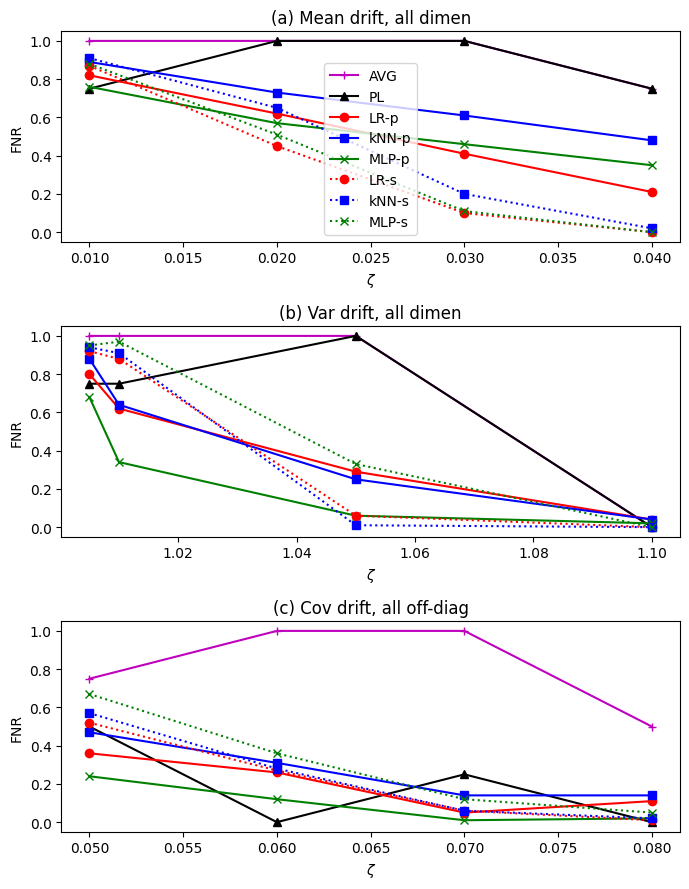

In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(7, 9))

'''Experiment 2b: Mean drift in all dimensions'''
zeta_lst = np.array([0.01, 0.02, 0.03, 0.04])
pval_AVG_FNR_lst =np.array([1,1,1,0.75])
pval_PL_FNR_lst = np.array([0.75,1,1,0.75])
pval_LR_FNR_lst = np.array([0.82, 0.62, 0.41, 0.21])
pval_kNN_FNR_lst = np.array([0.89, 0.73, 0.61, 0.48])
pval_MLP_FNR_lst = np.array([0.76, 0.57, 0.46, 0.35])
stat_LR_FNR_lst = np.array([0.87, 0.45, 0.1, 0])
stat_kNN_FNR_lst = np.array([0.91, 0.65, 0.2, 0.02])
stat_FNR_lst = np.array([0.88, 0.51, 0.11, 0])
axes[0].plot(zeta_lst, pval_AVG_FNR_lst, marker='+', c='m', label='AVG')
axes[0].plot(zeta_lst, pval_PL_FNR_lst, marker='^', c='k', label='PL')
axes[0].plot(zeta_lst, pval_LR_FNR_lst, marker='o', c='r', label='LR-p')
axes[0].plot(zeta_lst, pval_kNN_FNR_lst, marker='s', c='b', label='kNN-p')
axes[0].plot(zeta_lst, pval_MLP_FNR_lst, marker='x', c='g', label='MLP-p')
axes[0].plot(zeta_lst, stat_LR_FNR_lst, marker='o', c='r', linestyle='dotted', label='LR-s')
axes[0].plot(zeta_lst, stat_kNN_FNR_lst, marker='s', c='b', linestyle='dotted', label='kNN-s')
axes[0].plot(zeta_lst, stat_FNR_lst, marker='x', c='g', linestyle='dotted', label='MLP-s')
axes[0].set_title("(a) Mean drift, all dimen")
axes[0].legend(loc="best")
axes[0].set(xlabel=r'$\zeta$', ylabel='FNR')

'''Experiment 3b: Variance drift in all dimensions'''
zeta_lst = np.array([1.005, 1.01, 1.05, 1.10])
pval_AVG_FNR_lst =np.array([1,1,1,0])
pval_PL_FNR_lst = np.array([0.75,0.75,1,0])
pval_LR_FNR_lst = np.array([0.8, 0.62, 0.29, 0.04])
pval_kNN_FNR_lst = np.array([0.88, 0.64, 0.25, 0.04])
pval_MLP_FNR_lst = np.array([0.68, 0.34, 0.06, 0.02])
stat_LR_FNR_lst = np.array([0.92, 0.88, 0.06, 0])
stat_kNN_FNR_lst = np.array([0.94, 0.91, 0.01, 0])
stat_FNR_lst = np.array([0.95, 0.97, 0.33, 0])
axes[1].plot(zeta_lst, pval_AVG_FNR_lst, marker='+', c='m', label='AVG')
axes[1].plot(zeta_lst, pval_PL_FNR_lst, marker='^', c='k', label='PL')
axes[1].plot(zeta_lst, pval_LR_FNR_lst, marker='o', c='r', label='LR-p')
axes[1].plot(zeta_lst, pval_kNN_FNR_lst, marker='s', c='b', label='kNN-p')
axes[1].plot(zeta_lst, pval_MLP_FNR_lst, marker='x', c='g', label='MLP-p')
axes[1].plot(zeta_lst, stat_LR_FNR_lst, marker='o', c='r', linestyle='dotted', label='LR-s')
axes[1].plot(zeta_lst, stat_kNN_FNR_lst, marker='s', c='b', linestyle='dotted', label='kNN-s')
axes[1].plot(zeta_lst, stat_FNR_lst, marker='x', c='g', linestyle='dotted', label='MLP-s')
axes[1].set_title("(b) Var drift, all dimen")
axes[1].set(xlabel=r'$\zeta$', ylabel='FNR')

'''Experiment 4: Covariance drift in all off-diagonals'''
zeta_lst = np.array([0.05, 0.06, 0.07, 0.08])
pval_AVG_FNR_lst =np.array([0.75,1,1,0.5])
pval_PL_FNR_lst = np.array([0.5,0,0.25,0])
pval_LR_FNR_lst = np.array([0.36, 0.26, 0.05, 0.11])
pval_kNN_FNR_lst = np.array([0.47, 0.31, 0.14, 0.14])
pval_MLP_FNR_lst = np.array([0.24, 0.12, 0.01, 0.02])
stat_LR_FNR_lst = np.array([0.52, 0.27, 0.06, 0.01])
stat_kNN_FNR_lst = np.array([0.57, 0.28, 0.06, 0.02])
stat_FNR_lst = np.array([0.67, 0.36, 0.12, 0.05])
axes[2].plot(zeta_lst, pval_AVG_FNR_lst, marker='+', c='m', label='AVG')
axes[2].plot(zeta_lst, pval_PL_FNR_lst, marker='^', c='k', label='PL')
axes[2].plot(zeta_lst, pval_LR_FNR_lst, marker='o', c='r', label='LR-p')
axes[2].plot(zeta_lst, pval_kNN_FNR_lst, marker='s', c='b', label='kNN-p')
axes[2].plot(zeta_lst, pval_MLP_FNR_lst, marker='x', c='g', label='MLP-p')
axes[2].plot(zeta_lst, stat_LR_FNR_lst, marker='o', c='r', linestyle='dotted', label='LR-s')
axes[2].plot(zeta_lst, stat_kNN_FNR_lst, marker='s', c='b', linestyle='dotted', label='kNN-s')
axes[2].plot(zeta_lst, stat_FNR_lst, marker='x', c='g', linestyle='dotted', label='MLP-s')
axes[2].set_title("(c) Cov drift, all off-diag")
axes[2].set(xlabel=r'$\zeta$', ylabel='FNR')

fig.tight_layout() 